In [1]:
import geopandas as gpd
import pandas as pd
from progressbar import progressbar as pbar

In [2]:
z = pd.read_parquet("/opt/data/clay-california-worldcover-rgbnir-vvvh-chips-embeddings-v1-combined.parquet")

In [3]:
m = gpd.read_parquet("/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels_mod-prec7pc_emb-v0-2-20240426.parquet")

In [4]:
z.head()

,chips,embeddings
0,s3://clay-california-worldcover-rgbnir-vvvh-ch...,"[-0.092387736, 0.06289999, 0.14823247, 0.05708..."
1,s3://clay-california-worldcover-rgbnir-vvvh-ch...,"[-0.09912827, 0.055867158, 0.16590388, 0.04337..."
2,s3://clay-california-worldcover-rgbnir-vvvh-ch...,"[-0.11831675, 0.06658777, 0.13290095, 0.036696..."
3,s3://clay-california-worldcover-rgbnir-vvvh-ch...,"[-0.11574778, 0.06557509, 0.10578355, 0.031810..."
4,s3://clay-california-worldcover-rgbnir-vvvh-ch...,"[-0.11810879, 0.06218237, 0.16002795, 0.039691..."


In [5]:
m.head()

,onehot_count,onehot_area,onehot_length,string_labels,col,row,geometry,split
chip_id,,,,,,,,
193c3415fc237,"[24, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 53, ...","[58033.967200952815, 58033.967200952815, 0.0, ...","[4913.205774298301, 4913.205774298301, 0.0, 0....","[amenity=*, amenity=parking, building=*, build...",78080,96000,"POLYGON ((-118.47200 33.97867, -118.47200 34.0...",train
1639b12583426,"[148, 148, 4171, 1245, 1891, 52, 938, 13, 32, ...","[160073.78667008967, 160073.78667008967, 80191...","[20966.344659970102, 20966.344659970102, 24881...","[amenity=*, amenity=parking, building=*, build...",78080,95744,"POLYGON ((-118.47200 34.00000, -118.47200 34.0...",train
253904d963d6a,"[65, 65, 200, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 29...","[101980.95118259436, 101980.95118259436, 71246...","[10597.989172272657, 10597.989172272657, 16664...","[amenity=*, amenity=parking, building=*, build...",77824,95744,"POLYGON ((-118.49333 34.00000, -118.49333 34.0...",train
00530dca88d4a,"[9, 9, 4897, 688, 4026, 0, 172, 10, 1, 0, 0, 0...","[17637.908172952746, 17637.908172952746, 10930...","[1925.4953839123748, 1925.4953839123748, 32065...","[amenity=*, amenity=parking, building=*, build...",77824,95488,"POLYGON ((-118.49333 34.02133, -118.49333 34.0...",train
0e554bbdbe661,"[80, 80, 4358, 1262, 2386, 59, 597, 27, 27, 0,...","[131950.60085068244, 131950.60085068244, 98472...","[13536.03447682216, 13536.03447682216, 283601....","[amenity=*, amenity=parking, building=*, build...",78080,95488,"POLYGON ((-118.47200 34.02133, -118.47200 34.0...",train


In [6]:
z.shape

(111698, 2)

In [7]:
z.iloc[0]['embeddings'].shape

(768,)

In [8]:
chip_aws_path = z.iloc[0]['chips']
chip_aws_path

's3://clay-california-worldcover-rgbnir-vvvh-chips/chips/worldcover_california_chip_102400_99072.tif'

In [9]:
col, row = [int(i) for i in chip_aws_path.split("/")[-1].split(".")[0].split("_")[-2:]]

In [69]:
col, row

(102400, 99072)

In [23]:
chipid_map = {}
not_found = []
too_many = []
for chip_aws_path in pbar(z.chips.values):
    col, row = [int(i) for i in chip_aws_path.split("/")[-1].split(".")[0].split("_")[-2:]]
    c = m[ (m['col']==col) & (m['row']==row) ]
    if len(c)==1:
        chipid_map[(col,row)] = c.index[0]
    elif len(c)==0:
embedding        not_found.append([col,row])
    elif len(c)==0:
        too_many.append([col,row])


100% (111698 of 111698) |################| Elapsed Time: 0:00:53 Time:  0:00:530004


In [24]:
len(not_found), len(too_many), len(chipid_map)

(28207, 0, 83491)

In [26]:
not_found[0]

[102656, 97536]

In [27]:
m.shape

(83609, 8)

In [29]:
m['split'].value_counts()

split
train    58690
test     13078
val      11841
Name: count, dtype: int64

In [70]:
embeddings_folder = "/opt/data/california-worldcover-chips/embeddings_v1.0"

In [71]:
import pickle
for _,i in pbar(z.iterrows(), max_value=len(z)):
    fname = i.chips.split("/")[-1].split(".")[0]+".pkl"
    with open(f"{embeddings_folder}/{fname}", "wb") as f:
        pickle.dump(i.embeddings, f)
    

100% (111698 of 111698) |################| Elapsed Time: 0:00:36 Time:  0:00:360003


In [21]:
from omegaconf import OmegaConf
import hydra
import numpy as np

In [11]:
conf = OmegaConf.load("../../configs/osmencoder-x.yaml")
conf.dataloader

{'_target_': 'earthtext.datamodules.chipmultilabel.ChipMultilabelModule', 'metadata_file': '/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels_mod-prec7pc_emb-v0-2-20240426.parquet', 'embeddings_folder': '/opt/data/california-worldcover-chips/embeddings_v0.2-20240426', 'chips_folder': '/opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips', 'get_osm_strlabels': True, 'get_osm_ohearea': True, 'get_osm_ohecount': True, 'get_osm_ohelength': True, 'embeddings_normalization': True, 'multilabel_threshold_osm_ohecount': 1, 'osmvector_normalization': True, 'batch_size': 32}

In [12]:
embeddings_folder = "/opt/data/california-worldcover-chips/embeddings_v1.0"

conf.dataloader.embeddings_folder = embeddings_folder
conf.dataloader.get_chip_id = True
conf.dataloader['embeddings_folder'], conf.dataloader.chips_folder, conf.dataloader.get_chip_id
conf.dataloader.embeddings_normalization = False

In [13]:
data = hydra.utils.instantiate(conf.dataloader)

2024-05-10 12:21:36.207 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:90 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:02 Time:  0:00:020000
2024-05-10 12:21:39.201 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:94 - read train split with 58598 chip files (out of 58690)
2024-05-10 12:21:39.202 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:99 - max cache size is -1
2024-05-10 12:21:39.629 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:90 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-10 12:21:40.231 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:94 - read val split with 11822 chip files (out of 11841)
2024-05-10 12:21:40.231 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:99 - max cache size is -1
2024-05-10 12:21:40.

In [14]:
data.train_dataset.get_chip_id

True

In [15]:
len(data.train_dataset) + len(data.val_dataset) + len(data.test_dataset)

83491

In [16]:
data.disable_chip_loading()

In [17]:
traindl = data.train_dataloader()

In [75]:
for batch in pbar(traindl):
    pass

100% (1832 of 1832) |####################| Elapsed Time: 0:00:15 Time:  0:00:150001


In [77]:
testdl = data.test_dataloader()
for batch in pbar(testdl):
    pass

100% (409 of 409) |######################| Elapsed Time: 0:00:03 Time:  0:00:030000


In [18]:
valdl = data.val_dataloader()
for batch in pbar(valdl):
    pass
    break

  0% (0 of 370) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

In [19]:
batch.keys()

dict_keys(['multilabel', 'chip_id', 'embedding', 'osm_strlabels', 'osm_ohearea', 'osm_ohecount', 'osm_ohelength'])

In [26]:
for ci in range(len(batch['chip_id'])):                       
    chip_id = batch['chip_id'][ci]
    col = m.loc[chip_id]['col']
    row = m.loc[chip_id]['row']
    fname = f"s3://clay-california-worldcover-rgbnir-vvvh-chips/chips/worldcover_california_chip_{col}_{row}.tif"
    ok = np.allclose(z[z.chips==fname].iloc[0].embeddings, batch['embedding'][ci])
    print (ok)
    break


True


In [29]:
import numpy as np
ci = np.random.randint(len(batch['chip_id']))
chip_id = batch['chip_id'][ci]
col = m.loc[chip_id]['col']
row = m.loc[chip_id]['row']
fname = f"s3://clay-california-worldcover-rgbnir-vvvh-chips/chips/worldcover_california_chip_{col}_{row}.tif"
np.allclose(z[z.chips==fname].iloc[0].embeddings, batch['embedding'][ci])

True

In [30]:
import pickle

In [31]:
with open("/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels_mod-prec7pc_emb-v0-2-20240426_embeddings_v1.0_meansstdevs.pkl", "rb") as f:
    d = pickle.load(f)

In [34]:
d['means'].keys()

dict_keys(['osm_counts', 'osm_areas', 'osm_lengths', 'embeddings'])

In [55]:
fname = f"s3://clay-california-worldcover-rgbnir-vvvh-chips/chips/worldcover_california_chip_{col}_{row}.tif"
fname

's3://clay-california-worldcover-rgbnir-vvvh-chips/chips/worldcover_california_chip_37632_11776.tif'

In [56]:
import numpy as np
np.allclose(z[z.chips==fname].iloc[0].embeddings, batch['embedding'][0])

True

In [57]:
 batch['embedding'][0][:10], z[z.chips==fname].iloc[0].embeddings[:10]

(tensor([-0.0998,  0.0810, -0.0187,  0.1351,  0.0835,  0.3186,  0.0655,  0.1875,
         -0.2679, -0.0590]),
 array([-0.09982982,  0.08101191, -0.01867879,  0.13510755,  0.08345962,
         0.31858194,  0.06550831,  0.18751638, -0.26793486, -0.05899944],
       dtype=float32))

In [ ]:
 batch['embedding'][0][:10]

In [39]:
z[z.chips==fname]

,chips,embeddings
85000,s3://clay-california-worldcover-rgbnir-vvvh-ch...,"[-0.099829815, 0.08101191, -0.01867879, 0.1351..."


In [45]:
import pandas as pd
import geopandas as gpd
from pyproj import CRS
epsg4326 = CRS.from_epsg(4326)


In [46]:
p = gpd.read_parquet("/opt/data/california-worldcover-chips/tmp/index_ca_m_3311601_ne_11_060_20220506.parquet")
p.crs = epsg4326

In [39]:
p.head()

,chipid,date,chip_index_x,chip_index_y,cloud_cover_percentage,nodata_percentage,geometry,embeddings
0,ca_m_3311601_ne_11_060_20220506-0-0,2022-05-06,0,0,0.0,0.0,"POLYGON ((-116.93800 34.00188, -116.93800 34.0...","[-0.13589296, 0.01969828, 0.1377942, 0.0061442..."
1,ca_m_3311601_ne_11_060_20220506-1-0,2022-05-06,1,0,0.0,0.0,"POLYGON ((-116.93633 34.00188, -116.93634 34.0...","[-0.13061136, 0.023048798, 0.15017103, 0.01665..."
2,ca_m_3311601_ne_11_060_20220506-2-0,2022-05-06,2,0,0.0,0.0,"POLYGON ((-116.93467 34.00188, -116.93467 34.0...","[-0.12934385, 0.025013905, 0.13805251, 0.01208..."
3,ca_m_3311601_ne_11_060_20220506-3-0,2022-05-06,3,0,0.0,0.0,"POLYGON ((-116.93301 34.00188, -116.93301 34.0...","[-0.13369878, 0.022911016, 0.14487253, 0.01227..."
4,ca_m_3311601_ne_11_060_20220506-4-0,2022-05-06,4,0,0.0,0.0,"POLYGON ((-116.93135 34.00188, -116.93135 34.0...","[-0.1251994, 0.028975882, 0.14029442, 0.015018..."


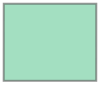

In [51]:
p.geometry.values[0]


In [47]:
p[['geometry']].explore()

In [48]:
c = gpd.read_parquet("/opt/data/california-worldcover-chips/osm/00048aee6feaf.parquet")
c.head()

,tags,geometry,kind,length,area,stags,chip_id
6518847025,"{'communication:mobile_phone': 'yes', 'man_mad...",POINT (-119.70974 36.79287),node,0.000000,0.0,communication:mobile_phone: yes\n<br>\nman_mad...,00048aee6feaf
6518847026,"{'communication:mobile_phone': 'yes', 'man_mad...",POINT (-119.70944 36.79287),node,0.000000,0.0,communication:mobile_phone: yes\n<br>\nman_mad...,00048aee6feaf
6948622430,{'barrier': 'gate'},POINT (-119.71004 36.79414),node,0.000000,0.0,barrier: gate,00048aee6feaf
9869647542,{'barrier': 'lift_gate'},POINT (-119.70973 36.78247),node,0.000000,0.0,barrier: lift_gate,00048aee6feaf
1369,"{'highway': 'service', 'surface': 'ground'}","LINESTRING (-119.71019 36.77555, -119.70933 36...",way,91.512679,0.0,highway: service\n<br>\nsurface: ground,00048aee6feaf


In [49]:
c.explore()